In [1]:
import pandas as pd
import json

In [2]:
with open('action.log', 'r') as f:
    action_logs = json.load(f)

with open('emotion.log', 'r') as f:
    emotion_logs = json.load(f)

In [3]:
pivot = 0
action_timestamps = list(action_logs.keys())
emotion_timestamps = list(emotion_logs.keys())

start = ''
for i, emotion_timestamp in enumerate(emotion_timestamps):
    if action_timestamps[0] <= emotion_timestamp:
        start = i
        break

for emotion_timestamp in emotion_timestamps[start:]:
    for k, action_timestamp in enumerate(action_timestamps[pivot:]):
        if abs(int(action_timestamp)-int(emotion_timestamp)) < 15:
            osizes = []
            fsizes = []

            action_log = action_logs[action_timestamp] # {obj_id: {'pos':..., 'actions':[...]}, obj_id: ...}
            emotion_log = emotion_logs[emotion_timestamp] # [{'pos':..., 'emotions':[...]}, ...]

            for obj_id, info in action_log.items():
                l, t, r, b = info['pos']
                size = (r-l)*(b-t)
                osizes.append((obj_id, size))

            for j, face in enumerate(emotion_log):
                l, t, r, b = face['pos']
                size = (r-l)*(b-t)
                fsizes.append((j, size))

            osizes.sort(key=lambda x:x[1])
            fsizes.sort(key=lambda x:x[1])

            row_nums = len(osizes)
            col_nums = len(fsizes)

            matrix = [[0]*col_nums for _ in range(row_nums)]

            for i in range(row_nums):
                l, t, r, b = action_log[osizes[i][0]]['pos']

                for j in range(col_nums):
                    fsize = fsizes[j] # (idx, size)
                    fl, ft, fr, fb = emotion_log[fsize[0]]['pos']

                    # overlapped grid
                    ovl = max(l, fl)
                    ovt = max(t, ft)
                    ovr = min(r, fr)
                    ovb = min(b, fb)

                    overlapped_size = (ovr-ovl)*(ovb-ovt)

                    matrix[i][j] = overlapped_size/fsize[1]
            
            for j in range(col_nums):
                col = [matrix[i][j] for i in range(row_nums)]
                overlapped_size_max = max(col)

                for i, overlapped_size in enumerate(col):
                    if overlapped_size == overlapped_size_max and j <= i:
                        emotion_log[fsizes[j][0]]['id'] = osizes[i][0]
                        break

            pivot += k
            break

In [4]:
emotion_logs['588144']

[{'pos': [547, 41, 901, 478],
  'emotions': [{'Type': 'CALM', 'Confidence': 95.04300689697266},
   {'Type': 'SURPRISED', 'Confidence': 1.2991604804992676},
   {'Type': 'CONFUSED', 'Confidence': 1.253407597541809},
   {'Type': 'SAD', 'Confidence': 1.2464255094528198},
   {'Type': 'ANGRY', 'Confidence': 0.6572962999343872},
   {'Type': 'DISGUSTED', 'Confidence': 0.24225889146327972},
   {'Type': 'HAPPY', 'Confidence': 0.13935160636901855},
   {'Type': 'FEAR', 'Confidence': 0.1190834790468216}]},
 {'pos': [1297, 289, 1664, 698],
  'emotions': [{'Type': 'CALM', 'Confidence': 89.92561340332031},
   {'Type': 'SAD', 'Confidence': 8.377433776855469},
   {'Type': 'CONFUSED', 'Confidence': 1.1029573678970337},
   {'Type': 'ANGRY', 'Confidence': 0.19668510556221008},
   {'Type': 'HAPPY', 'Confidence': 0.1397676169872284},
   {'Type': 'FEAR', 'Confidence': 0.1054452583193779},
   {'Type': 'SURPRISED', 'Confidence': 0.08679395914077759},
   {'Type': 'DISGUSTED', 'Confidence': 0.06530400365591049}],

In [5]:
list(action_logs.keys())[-10:]

['588033',
 '588066',
 '588100',
 '588133',
 '588166',
 '588200',
 '588233',
 '588266',
 '588300',
 '588333']

In [6]:
action_logs['588133']

{'1': {'pos': [1103, 2, 1613, 643],
  'actions': [{'action': 'sit', 'confidence': 0.78},
   {'action': 'watch sb.', 'confidence': 0.59}]}}

In [7]:
list(emotion_logs.keys())[:25]

['0',
 '499',
 '999',
 '1499',
 '1999',
 '2499',
 '2999',
 '3499',
 '3999',
 '4499',
 '4999',
 '5499',
 '5999',
 '6499',
 '6999',
 '7499',
 '7999',
 '8499',
 '8999',
 '9499',
 '9999',
 '10499',
 '10999',
 '11499',
 '11999']

In [8]:
target_emotion_log = emotion_logs['3499']
target_emotion_log

[{'pos': [1062, 280, 1148, 345],
  'emotions': [{'Type': 'SAD', 'Confidence': 97.9140853881836},
   {'Type': 'CALM', 'Confidence': 1.6569465398788452},
   {'Type': 'FEAR', 'Confidence': 0.3362767994403839},
   {'Type': 'HAPPY', 'Confidence': 0.04481841251254082},
   {'Type': 'CONFUSED', 'Confidence': 0.020730068907141685},
   {'Type': 'ANGRY', 'Confidence': 0.012081298977136612},
   {'Type': 'DISGUSTED', 'Confidence': 0.008006023243069649},
   {'Type': 'SURPRISED', 'Confidence': 0.0070500243455171585}],
  'id': '8'},
 {'pos': [1104, 191, 1198, 287],
  'emotions': [{'Type': 'SAD', 'Confidence': 95.05645751953125},
   {'Type': 'CALM', 'Confidence': 3.7288970947265625},
   {'Type': 'ANGRY', 'Confidence': 0.47171422839164734},
   {'Type': 'HAPPY', 'Confidence': 0.4316859841346741},
   {'Type': 'SURPRISED', 'Confidence': 0.18174779415130615},
   {'Type': 'CONFUSED', 'Confidence': 0.062001023441553116},
   {'Type': 'FEAR', 'Confidence': 0.04752373695373535},
   {'Type': 'DISGUSTED', 'Confide

In [9]:
emotion_dataframes_by_id = {}
emotion_dataframe_columns = ['timestamp', 'emotion', 'conf']

for timestamp, emotion_log in emotion_logs.items():
    for face in emotion_log:
        if 'id' in face:
            obj_id = face['id']

            if obj_id not in emotion_dataframes_by_id:
                emotion_dataframes_by_id[obj_id] = pd.DataFrame()

            emotion = face['emotions'][0]['Type']
            conf = face['emotions'][0]['Confidence']
            data = [[timestamp, emotion, conf]]
            emotion_dataframes_by_id[obj_id] = emotion_dataframes_by_id[obj_id].append(
                pd.DataFrame(data=data, columns=emotion_dataframe_columns)
            )

emotion_dataframes_by_id

{'1':    timestamp emotion       conf
 0       1499    CALM  50.770676
 0       1999    CALM  81.738579
 0       2499     SAD  72.262833
 0       2999    CALM  68.535667
 0       3499     SAD  95.056458
 ..       ...     ...        ...
 0     586999     SAD  44.677849
 0     587139    CALM  89.067108
 0     587499    CALM  97.885704
 0     587642    CALM  83.231018
 0     588144    CALM  89.925613
 
 [1185 rows x 3 columns],
 '8':    timestamp emotion       conf
 0       3499     SAD  97.914085
 0       3999     SAD  84.128754
 0       4499     SAD  75.194061
 0       7999     SAD  57.605076
 0       9999     SAD  94.608429
 ..       ...     ...        ...
 0     584999    CALM  86.258598
 0     585499    CALM  91.905365
 0     585999    CALM  95.391930
 0     586499    CALM  92.026527
 0     586999    CALM  95.432564
 
 [619 rows x 3 columns],
 '18':   timestamp emotion       conf
 0      6999     SAD  93.913261,
 '140':   timestamp emotion       conf
 0    267999     SAD  90.298393,


In [10]:
emotion_dataframes_by_id['8']

,timestamp,emotion,conf
0,3499,SAD,97.914085
0,3999,SAD,84.128754
0,4499,SAD,75.194061
0,7999,SAD,57.605076
0,9999,SAD,94.608429
...,...,...,...
0,584999,CALM,86.258598
0,585499,CALM,91.905365
0,585999,CALM,95.391930
0,586499,CALM,92.026527


In [11]:
emotion_dataframes_by_id['1'].emotion.value_counts()

CALM         531
SAD          488
HAPPY         66
ANGRY         59
FEAR          24
SURPRISED     13
DISGUSTED      3
CONFUSED       1
Name: emotion, dtype: int64

In [12]:
emotion_dataframes_by_id['8'].emotion.value_counts()

CALM         429
SAD          107
HAPPY         46
FEAR          25
CONFUSED       6
SURPRISED      4
DISGUSTED      1
ANGRY          1
Name: emotion, dtype: int64

In [13]:
type(emotion_dataframes_by_id['8'].emotion.value_counts())

pandas.core.series.Series

In [14]:
emotion_labels = list(emotion_dataframes_by_id['1'].emotion.value_counts().index)
emotion_freqs = list(emotion_dataframes_by_id['1'].emotion.value_counts().values)

print(f'emotion_labels: {emotion_labels}')
print(f'emotion_freqs: {emotion_freqs}')

emotion_labels: ['CALM', 'SAD', 'HAPPY', 'ANGRY', 'FEAR', 'SURPRISED', 'DISGUSTED', 'CONFUSED']
emotion_freqs: [531, 488, 66, 59, 24, 13, 3, 1]


type(pie_result): <class 'tuple'>
pie_result: ([<matplotlib.patches.Wedge object at 0x00000154B18E6088>, <matplotlib.patches.Wedge object at 0x00000154B18F2388>, <matplotlib.patches.Wedge object at 0x00000154B18F93C8>, <matplotlib.patches.Wedge object at 0x00000154B18FF448>, <matplotlib.patches.Wedge object at 0x00000154B19074C8>, <matplotlib.patches.Wedge object at 0x00000154B190D5C8>, <matplotlib.patches.Wedge object at 0x00000154B1915608>, <matplotlib.patches.Wedge object at 0x00000154B191A648>], [Text(0.17855562840563646, 1.0854113909318754, 'CALM'), Text(-0.6239479273535729, -0.9059188616819834, 'SAD'), Text(0.837629013267378, -0.7130060561683321, 'HAPPY'), Text(1.0240371427097479, -0.40168137914378815, 'ANGRY'), Text(1.0870214331068115, -0.1684767163925435, 'FEAR'), Text(1.0982956664143841, -0.06120971438737585, 'SURPRISED'), Text(1.0999033571470627, -0.014580978589282907, 'DISGUSTED'), Text(1.0999961338629254, -0.0029164167427111515, 'CONFUSED')], [Text(0.09739397913034716, 0.59

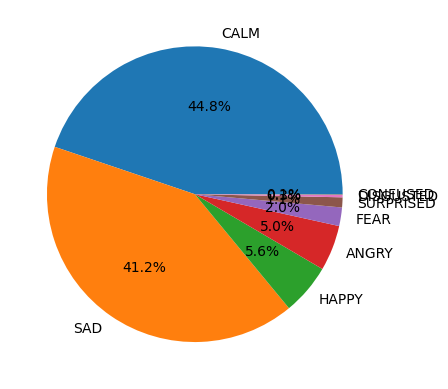

In [15]:
import matplotlib.pyplot as plt

pie_result = plt.pie(emotion_freqs, labels=emotion_labels, autopct='%.1f%%')
print(f'type(pie_result): {type(pie_result)}')
print(f'pie_result: {pie_result}')
plt.show()

In [16]:
total_freq = sum(emotion_freqs)
emotion_distribution = list(map(lambda x:x/total_freq, emotion_freqs))
emotion_distribution

[0.4481012658227848,
 0.4118143459915612,
 0.05569620253164557,
 0.049789029535864976,
 0.020253164556962026,
 0.010970464135021098,
 0.002531645569620253,
 0.0008438818565400844]

In [17]:
prop_sum = 0
thres_idx = 0

for i, prop in enumerate(emotion_distribution):
    prop_sum += prop

    if 0.8 <= prop_sum:
        thres_idx = i
        break

In [18]:
df = emotion_dataframes_by_id['8']

for emotion in emotion_labels[:thres_idx+1]:
    df[emotion] = 0
    df.loc[df.emotion == emotion, emotion] = df[df.emotion == emotion].conf

df

,timestamp,emotion,conf,CALM,SAD
0,3499,SAD,97.914085,0.000000,97.914085
0,3999,SAD,84.128754,0.000000,84.128754
0,4499,SAD,75.194061,0.000000,75.194061
0,7999,SAD,57.605076,0.000000,57.605076
0,9999,SAD,94.608429,0.000000,94.608429
...,...,...,...,...,...
0,584999,CALM,86.258598,86.258598,0.000000
0,585499,CALM,91.905365,91.905365,0.000000
0,585999,CALM,95.391930,95.391930,0.000000
0,586499,CALM,92.026527,92.026527,0.000000


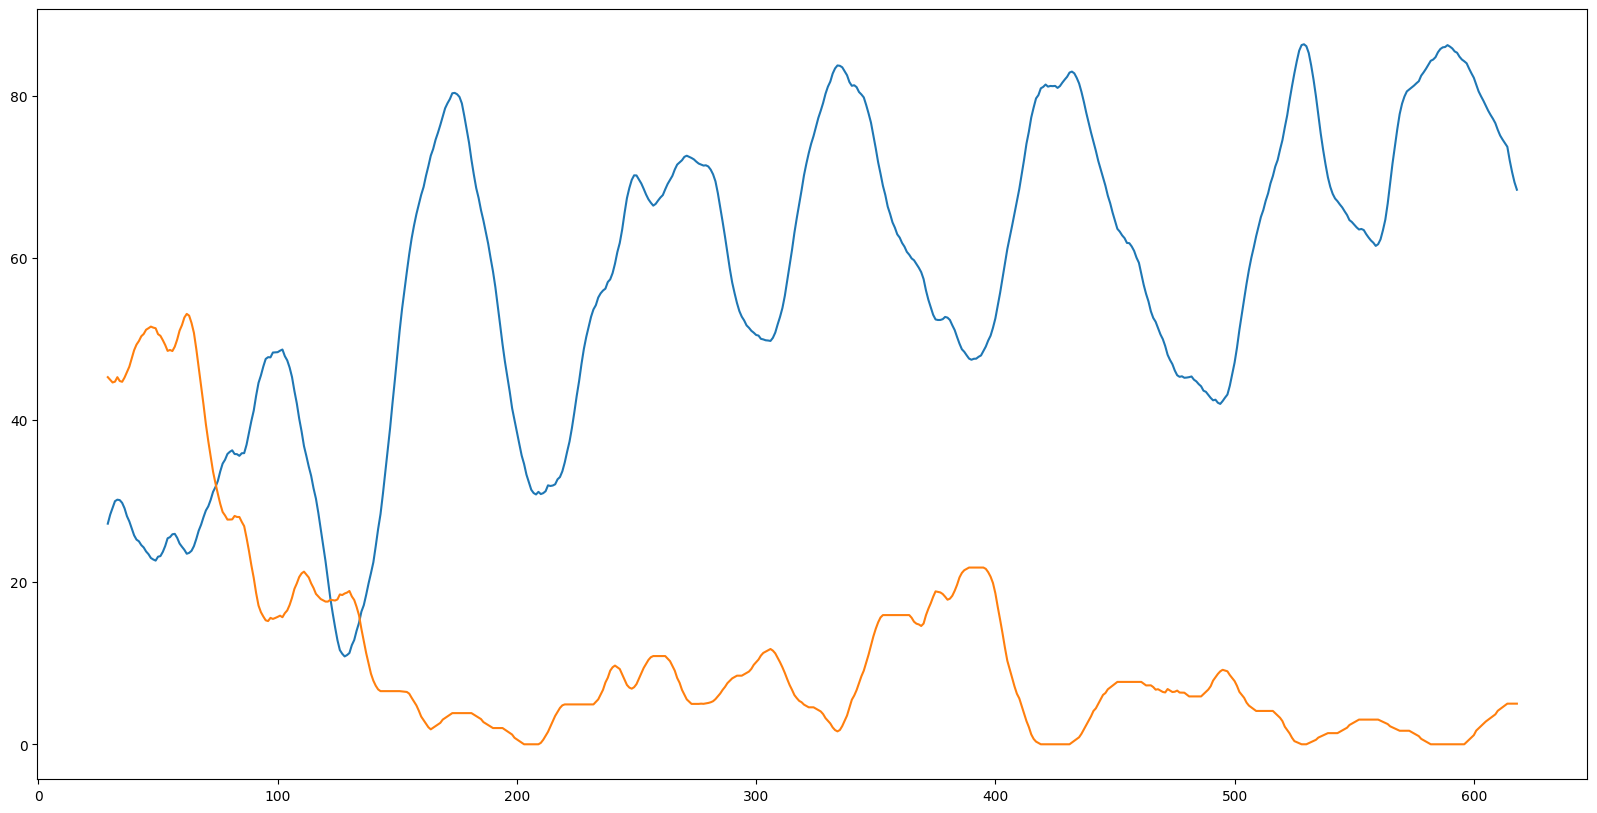

In [19]:
df = df.reset_index()

for emotion in emotion_labels[:thres_idx+1]:
    (((df.eval(emotion).rolling(5).mean().fillna(0) + df.eval(emotion)[::-1].rolling(5).mean().fillna(0)[::-1]))/2).rolling(30).mean().plot(figsize=(20, 10))
    # df.eval(emotion).rolling(5).mean().fillna(0).rolling(30).mean().plot(figsize=(30, 20))

plt.show()